In [1]:
%matplotlib inline

# libs

# data
import pandas as pd
import numpy as np

# CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

# plot
import matplotlib.pyplot as plt

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
path = './data/full.csv'

# load full data
D = pd.read_csv(path, index_col=0)

In [3]:
# extract inputs/targets
target_cols = list(filter(lambda x: 'c1_c0' in x, D.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, D.columns.values))
InputDF = D[input_cols]
TargetDF = D[target_cols]

# into numpy format
InputDF = InputDF.as_matrix()
TargetDF = TargetDF.as_matrix()

In [4]:
# 6 values, from 440 symbols, over 2768 days
total_days = InputDF.shape[0]
channels = 6
tickers = InputDF.shape[1]/channels
InputDF = np.reshape(InputDF, (total_days, tickers, channels))

In [5]:
# data params
test_size = 500;
window_size = 28;

X_train = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1) )])
X_test = np.array([InputDF[i:i + window_size] for i in range(InputDF.shape[0] - (test_size + window_size - 1), InputDF.shape[0] - window_size + 1)])

def decision(x):
    margin = 0.005
    labels = np.zeros(x.shape)
    labels[np.where(x > np.log(1 + margin))] = 1
    labels[np.where(x < np.log(1 - margin))] = -1
    return labels


norm_min = TargetDF.min()
norm_max = (TargetDF - TargetDF.min()).max()
y_all = (TargetDF - norm_min) / norm_max
y_train = y_all[window_size - 1 : -test_size]
y_test = y_all[-test_size:]

# data shape
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

print y_all.min()
print y_all.max()
print y_all.mean()
print y_all.std()

# print '+1 ', len(np.where(y_all == 1)[1])
# print '-1 ', len(np.where(y_all == -1)[1])
# print '=0 ', len(np.where(y_all == 0)[1])

(2241, 28, 440, 6) (2241, 440)
(500, 28, 440, 6) (500, 440)
0.0
1.0
0.620646299942
0.0130765677678


In [6]:
# KERAS STARTS HERE
batch_size = 32
epochs = 30

# dimensions
input_shape = (window_size, tickers, channels)

In [13]:
# model definition
# ADD PADDING??
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(440))
model.add(Activation('sigmoid'))

print model.summary()

# model.load_weights('weights-lowhidden.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 436, 16)       2416      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 434, 32)       4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 217, 32)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 76384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              78218240  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
__________

In [14]:
sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=sgd)

# tensorboard = keras.callbacks.TensorBoard(log_dir='./logs/10')
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 2241 samples, validate on 500 samples
Epoch 1/30
2241/2241 [==============================] - 4s - loss: 0.6926 - val_loss: 0.6832

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)

print 'Test loss:', score
# print('Test accuracy:', score[1])

Test loss: 0.664578769684


[[-0.00193236  0.00302952  0.00781791 ...,  0.00557145  0.00322642
   0.0007386 ]
 [ 0.0036189  -0.01093058 -0.00020941 ...,  0.00717803 -0.00201327
  -0.02936796]
 [ 0.00096316  0.00243727  0.0067774  ...,  0.01178188 -0.01012759
  -0.00075869]
 ..., 
 [-0.00417328 -0.01152079  0.00717641 ...,  0.00719771  0.00141272
   0.00240006]
 [-0.01937922 -0.01400247 -0.01193081 ..., -0.01089438 -0.00612679
  -0.01692575]
 [ 0.02526615  0.01747325  0.0412493  ...,  0.02333262  0.00941071
   0.0140755 ]]
[[-0.03012764 -0.03528416 -0.03400683 ..., -0.04006672 -0.03844786
  -0.02514374]
 [-0.03733242 -0.02836132 -0.03519058 ..., -0.0367434  -0.03879654
  -0.02294147]
 [-0.04478061 -0.03984618 -0.03885901 ..., -0.04320335 -0.0417006
  -0.03351676]
 ..., 
 [-0.03815818 -0.019642   -0.03088915 ..., -0.03307021 -0.02659404
  -0.02398944]
 [-0.04701328 -0.03901899 -0.03750908 ..., -0.03852344 -0.03457963
  -0.0324167 ]
 [-0.05310547 -0.04096663 -0.04291737 ..., -0.05353022 -0.04222488
  -0.05131209]]


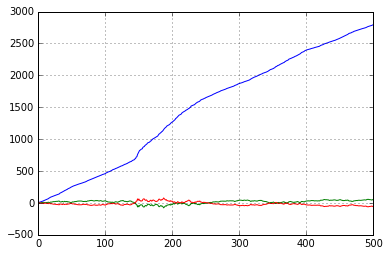

[[-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]
 ..., 
 [-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]
 [-1. -1. -1. ..., -1. -1. -1.]]
[[ 0.  0.  1. ...,  1.  0.  0.]
 [ 0. -1.  0. ...,  1.  0. -1.]
 [ 0.  0.  1. ...,  1. -1.  0.]
 ..., 
 [ 0. -1.  1. ...,  1.  0.  0.]
 [-1. -1. -1. ..., -1. -1. -1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
Accuracy:  0.340490909091


In [16]:
predictions = model.predict(X_test, batch_size=1)

def normalize(x):
    pve = np.percentile(predictions, 66)
    nve = np.percentile(predictions, 33)
    print 'pve ', pve
    print 'nve ', nve
    norms = np.zeros(x.shape)
    norms[np.where(x > pve)] = 1
    norms[np.where(x < nve)] = -1
    return norms


# print predictions.max()
# print predictions.min()

predictions_norm = (predictions *  norm_max) + norm_min
y_test_norm = (y_test * norm_max) + norm_min

# print predictions_norm.max()
# print predictions_norm.min()

print y_test_norm
print predictions_norm


x_axis = np.arange(len(y_test))

fig, ax = plt.subplots()

ax.plot(x_axis, (decision(y_test_norm) * TargetDF[-test_size:]).sum(1).cumsum())
ax.plot(x_axis, (1 * TargetDF[-test_size:]).sum(1).cumsum())
ax.plot(x_axis, (decision(predictions_norm) * TargetDF[-test_size:]).sum(1).cumsum())

# print normalize(predictions)
# ax.set_ylim(ymin=-500, ymax=2500)
ax.set_xlim(xmin=0, xmax=500)

# ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')

plt.grid()
plt.show()

print decision(predictions_norm)
print decision(y_test_norm)

print 'Accuracy: ', np.sum(decision(predictions_norm) == decision(y_test_norm)) / float(y_test.shape[0] * y_test.shape[1]) 

# def labeler(x):
#     margin = 0.005
#     labels = np.zeros(x.shape)
#     labels[np.where(x > np.log(1 + margin))] = 1
#     labels[np.where(x < np.log(1 - margin))] = -1
    
#     return labels

# returns = np.apply_along_axis(labeler,
#                               axis=1,
#                               arr=predictions)

# # print predictions
# # print '---------------------------------------------------------'
# # print y_test
# # print '---------------------------------------------------------'
# print len(np.where(returns == 1)[1])
# print len(np.where(returns == -1)[1])
# print len(np.where(returns == 0)[1])

In [ ]:
# DO NOT RUN THIS YET

# model.save_weights('weights-lowhidden.h5')

In [ ]:
# print normalize(predictions) * TargetDF[-test_size:]
# print (normalize(predictions) * TargetDF[-test_size:]).sum(1).cumsum()